In [1]:
try:
    import rlmep

    print("Already installed")
except ImportError:
    %pip install "rlmep @ git+https://github.com/Mads-PeterVC/rlmep.git" # if you are using Google Colab

/home/luuk/rlmep/.venv/lib/python3.11/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


Already installed


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from rich.progress import track

%matplotlib inline

In order to make the exercises at little more accessible some of the code has been implemented 
as part of the small `rlmep`-package. Some exercises will import small functions or classes from this package. 
If you're curious about the details of a particular function you can view the source code or have jupyter show it as 
is done in the cell below.

In [3]:
from rlmep import example_function

example_function??

Signature: example_function(a: int)
Source:   
def example_function(a: int):
    """
    This is an example function for showing the use of the ??-magic.
    """
    return a + 1
File:      ~/rlmep/src/rlmep/example_function.py
Type:      function

# Q-learning

## The 'Frozen Lake'-environment

To start with we will get some familiarity with reinforcement learning by applying Q-learning 
to a problem that is not directly related to materials science. 

A convenient library is `gymnasium` which supplies a consistent API for defining 
environments and supplies a number of toy environments.

In [4]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=False)

In the `FrozenLake`-environment our agent is guiding an adventurer across a frozen lake, 
in certain spots the ice is too thin and the poor adventurer will fall through and die. 
However, if the adventurer navigates across the ice properly he can reach a gift. 

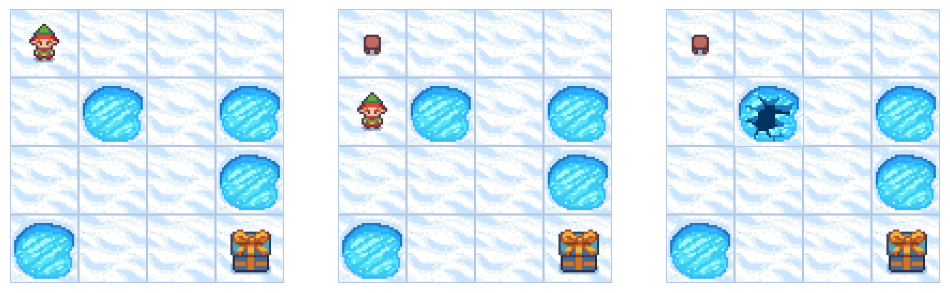

In [ ]:
state = env.reset()
sz = 4

actions = [None, 1, 2]
fig, axs = plt.subplots(1, len(actions), figsize=(len(actions) * sz, 1 * sz))

for ax, action in zip(axs, actions):
    if action is not None:
        _ = env.step(action)

    ax.imshow(env.render())

    ax.axis("off")

Exercise: Try a different sequence of actions

Some important aspects of an environment are the action and state spaces.

We can inspect these like done below

In [11]:
# Check if an action is part of the space.
contains_action = [env.action_space.contains(a) for a in range(5)]
print(f"{env.action_space = }")
print(f"{contains_action = }")

# Sample an action from the space.
sampled_action = env.action_space.sample()
print(f"{sampled_action = }\n")

# The observation space
print(f"{env.observation_space = }")

env.action_space = Discrete(4)
contains_action = [True, True, True, True, False]
sampled_action = np.int64(2)

env.observation_space = Discrete(16)


This tells us that for each state there are 4 discrete actions and there are 16 states - 
which matches the figures from above.

## Tabular Q-learning


### Temporal difference derivation

Now that we have an environment, the second thing we need is an algorithm. We will be using Q-learning with a table. 

Here Q is the action-value function, from the Bellman equation: 

$$ Q(s_t, a_t) = \mathbb{E}_{s^*} [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s^*, a^*)] $$

The expectation value here is over the possible states resulting from taking action $a$ in state $s$. $\gamma$ is the discount factor, 
it weights the importance of future rewards. 
Given that we have our environment has deterministic transition function we can ignore that expectation value and 
reach the equation

$$ Q(s_t, a_t) = [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s_{t+1}, a^*)] $$

So, for a given state-action pair $(s_t, a_t)$ the Q-value is the sum of the reward and the maximum of the next state. 
Initially we dont know Q, so we will need a learning algorithm. To reach such an algorithm we write an error

$$ [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} Q(s_{t+1}, a^*)] - Q(s_t, a_t) $$

To minimize that, we can update the Q-value according to

$$
\begin{align}
Q(s_t, a_t) &\leftarrow Q(s_t, a_t) + \alpha \Big( [r_t + \gamma \mathrm{max}_{a^*} Q(s_{t+1}, a^*)] - Q(s_t, a_t) \Big) 
\end{align}
$$

Where $\alpha$ is a learning rate parameter, if $\alpha = 1$ we can see that this update rule reduces to just setting 

$$ Q(s_t, a_t) \leftarrow [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s_{t+1}, a^*)] $$

Which is essentially taking the Bellman equation and changing the equals sign to an arrow. 
This is the **temporal difference** target. 

At each step you will need to calculate 

$$
\Delta Q(s_t, a_t) = \Big( [r_t + \gamma \mathrm{max}_{a^*} Q(s_{t+1}, a^*)] - Q(s_t, a_t) \Big) 
$$

And then update the Q-table for that action

$$
Q(s_t, a_t) \mathrel{{+}{=}}  \alpha \Delta Q(s_t, a_t)
$$


### $\epsilon$-greedy policy

Reinforcement learning often happens in 'episodes' of letting the 'agent'/algorithm explore the environment, gathering 
information and possibly training. Our agent in this case is defined by the Q-table, generally in RL we say that the agent follows a 'policy', in this case our policy will mostly be to choose actions according to $\mathrm{argmax}(Q(s, a))$. In order to have some exploration of the environment we will modify this greedy strategy, leading us to a so-called $\epsilon$-greedy policy. 

It goes as follows: 
- Draw some random number $z$
- If $z < \epsilon$ draw a random action. 
- Else choose according to $\mathrm{argmax} \ Q(s, s)$

### Algorithm

Now we have all the elements required for our algorithm, so lets put it together. 

Our algorithm will thus be as follows: 

- Create a Q-table of just zeros of size (16, 4)

1. Choose an action according to the $\epsilon$-greedy strategy. 
2. Take a step in the environment with that action, resulting in the next state, reward and a signal of whether the state is terminal or not. 
3. Update the Q-value according to the temporal difference rule from above. 
4. If the action lead to a terminal state end the episode. 

### Exercise: 

Finish the tabular Q-learning algorithm below. 

The following cell will plot the Q-values which you can use to check if your algorithm works.

In [16]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=False)

Q_table = np.zeros((16, 4), dtype=np.float64)

Q_table = np.random.uniform(low=-1, high=1, size=(16, 4))

# Hyperparameters
epsilon = 0.5
learning_rate = 1
gamma = 0.9
num_episodes = 250


for episode in track(range(num_episodes)):
    state, _ = env.reset()
    terminal = False
    truncated = False

    while not terminal and not truncated:
        # Choose action
        # If random number is less than epsilon, then select a random action
        # Else select according to the Q-values. When selecting according to Q-values,
        # if all actions have the same Q-value, then select a random action.
        # This is done as argmax will always select the first index in the case of a tie.
        if np.random.rand() < epsilon:
            action = env.action_space.sample() # Your code here
        else:
            if (Q_table[state, :] == Q_table[state, 0]).all(): # If all actions have the same Q-value
                action = env.action_space.sample() # Your code here
            else:
                action = np.argmax(Q_table[state, :]) # Your code here

        # Take action by calling env.step
        next_state, reward, terminal, truncated, info = env.step(action)

        # Calculate Q-target
        if not terminal:
            Q_target = reward + gamma * np.max(Q_table[next_state, :])
        else:
            Q_target = reward

        # Update Q-table
        Q_table[state, action] += learning_rate * (Q_target - Q_table[state, action])

        state = next_state

Output()

In order to figure out whether things are working, the following cell will plot the Q-values learned by your agent. 

The figure shows the learned Q-values for each action of each state, if any of the Q-values differ from zero. 
To understand from the visualization whether your implementation is working or not, you should consider the 
following questions;

- What should the Q-value be for state-action pairs that lead to the goal be? 
- What should Q-values for state-actions pairs that lead to hole tiles be? 
- How should the Q-values depend on the discount factor $\gamma$? 
- What should the Q-values for illegal actions be? (E.g. actions that attempt to move the adventurer out of the grid.) 

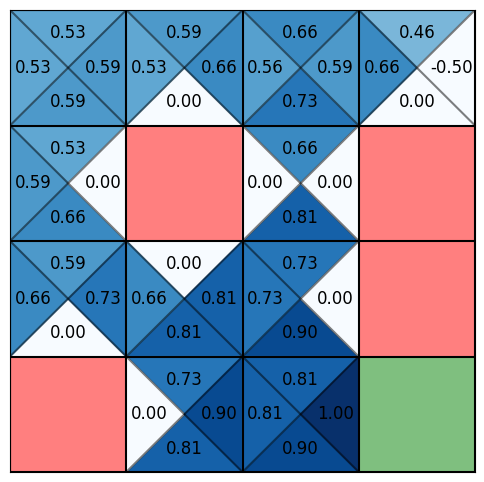

In [17]:
from rlmep.exercise_1 import plot_qvalues

plot_qvalues(Q_table, env=env)

#### Exercise:

As a final task for this tabular Q-learning algorithm try to alter your code such that it works with an initial Q-table that is not just zeros. This will be relevant for an upcoming topic, Q-learning with neural networks where we cannot easily ensure that initial Q-values are all zero. 

At first just change such that the initial Q-table is initialized randomly; 

```python
Q_table = np.random.uniform(low=-1, high=1, size=(16, 4))
```
and rerun the training of the algorithm.  What happens? Can you fix it? 

<br> 

<details>
<summary> <strong> Hint </strong> </summary>

Unless you had a lot of foresight while implementing your training loop this likely doesn't work. 
The issue stems from the update rule

$$ \Delta Q(s_t, a_t) = \Big( r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s_{t+1}, a^*) - Q(s_t, a_t) \Big) $$

Which is only valid for actions that lead to **non-terminal** states, otherwise we should 
apply the rule

$$ \Delta Q(s_t, a_t) = \Big( r(s_t, a_t) - Q(s_t, a_t) \Big) \ \mathrm{if} \ s_{t+1} \ \mathrm{is \ terminal}$$

To fix this in the training loop you can just have an `if`-statement when calculating the `Q_target`:

```python
if not terminal:
    Q_target = ...
else:
    Q_target = ...
```
</details>



## Q-network rather than Q-table. 

Having a table in 2025 is very embarrassing, so let's replace that table with a network. 

What do we want from that network? We want it to be able to predict action-values $Q$ \
given a state and an action, but that is not completely specific. 

We have multiple options: 
- The network could take both a state $s$ and an action $a$ and predict a single Q-value; 
- The network could take only the state and predict all Q-values for that particular state. 

We will opt for the second option, but the first one should work as well. 

So for this option we want a network that 
- Takes a state representation as an input; 
- Outputs 4 numbers corresponding to the 4 actions available for each state. 

Finish the implementation of the `Qnet`-class below, this involves; 

- `build_network`: Should create a neural network with the right input and output shapes.
- `train`: Should perform a single training step.

<details>
<summary> <strong> Hint: Neural networks </strong> </summary>

Your network should consists of `torch.nn.Linear`-layers with some activation function, e.g. `torch.nn.ReLU`. 

Initialization of `torch.nn.Linear` takes the input dimension and the output dimension. 

To create a stack of layers you can use `torch.nn.Sequential`.

</details>

<br> 

<details>
<summary> <strong> Hint: Training step </strong> </summary>

You can use `torch.nn.functional.mse_loss` or you can just write it out as an element-wise array operation - like numpy. 

To calculate gradient just put `loss.backward()`. 

</details>




In [18]:
import torch
from typing import Callable


class Qnet(torch.nn.Module):
    def __init__(
        self,
        learning_rate=1e-3,
        hidden_dim=16,
        input_dim=1,
        output_dim=4,
        network_kwargs: dict | None = None,
        state_transform: Callable | None = None,
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        if network_kwargs is None:
            network_kwargs = {}

        if state_transform is None:
            state_transform = lambda x: x  # noqa: E731

        self.network = self.build_network(
            input_dim, hidden_dim, output_dim, **network_kwargs
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.state_transform = state_transform

    def build_network(self, input_dim: int, hidden_dim: int, output_dim: int, **kwargs):
        network = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        ) # Your code here

        return network

    def forward(self, x):
        """
        Forward pass through the network.

        This method takes an input tensor `x`, applies the state transformation,
        and computes the Q-values for each action.
        """
        x = self.state_transform(x)
        q = self.network(x).view(-1, self.output_dim)
        return q

    def train(self, states: torch.Tensor, actions: torch.Tensor, targets: torch.Tensor):
        # Forward pass
        Q_values = self.forward(states) # Your code here

        # This selects Q corresponding to the actions taken
        Q_action = Q_values[range(Q_values.shape[0]), actions]

        # Compute loss: MSE between Q_action and targets
        loss = torch.nn.functional.mse_loss(Q_action, targets) # Your code here

        # Calculate gradients
        loss.backward() # Your code here

        # Take step and reset gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        return (
            loss.detach().numpy()
        )  # Returning just for book-keeping, not necessary for training

In this cell you can check your networks forward pass works as expected.

In [19]:
from rlmep.exercise_1 import Qnet

# Check that our network works as expected.
model = Qnet(input_dim=1, output_dim=4)
s = torch.tensor([0], dtype=torch.float32)
Q = model.forward(s)

print(Q.shape)
print(Q)
assert Q.shape == (1, 4)

torch.Size([1, 4])
tensor([[ 0.0284,  0.0084,  0.1370, -0.0819]], grad_fn=<ViewBackward0>)


Now to test that our network is working and capable of expressing the Q-table we can try 
to just train it towards table we created before.

I provided the function `state_transform` that turns the integer representation of 
the state into a grid coordinate representation with two integers. 

Try training with and without the `state_transform` - remember that this changes the input dimension of 
the network.

In [24]:
from rlmep.exercise_1 import get_batch


def state_transform(state):
    i = state // 4
    j = state % 4
    return torch.hstack([i, j])


# Train the network
model = Qnet(learning_rate=1e-3, input_dim=2, state_transform=state_transform)
# model = Qnet(learning_rate=1e-3, input_dim=1, state_transform=None)
loss = []
for _ in track(range(5000), description="Training Q-network"):
    states, actions, targets = get_batch(Q_table, size=16)
    l = model.train(states, actions, targets)  # Your code here
    loss.append(l)

Output()

Now we can evaluate all the predictions and plot against the table.

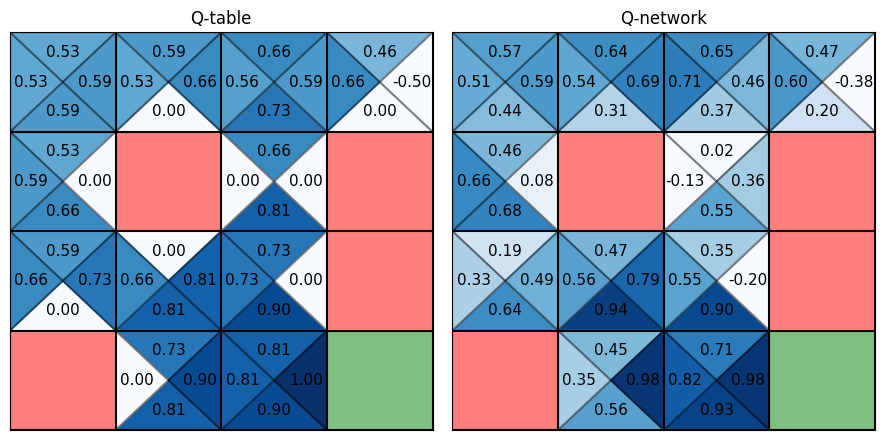

In [25]:
# Make a table of its predictions:
Q_table_nn = np.zeros((16, 4), dtype=np.float64)

for state in range(16):
    state_tensor = torch.tensor([state], dtype=torch.float32)
    Q_table_nn[state] = model.forward(state_tensor).detach().numpy()

sz = 4.5
fig, axs = plt.subplots(1, 2, figsize=(2 * sz, 1 * sz))

plot_qvalues(Q_table, env=env, ax=axs[0], fs=11)
plot_qvalues(Q_table_nn, env=env, ax=axs[1], fs=11)

axs[0].set_title("Q-table")
axs[1].set_title("Q-network")
plt.tight_layout()


## Deep Q-Network: Q-learning with neural networks.

When running an episode for the training of the Q-table we updated the table every step, 
whereas when we trained the network towards the table we used batches of data. 

Using batches is both more efficient in terms of computational speed, but also provides 
more reliable gradients - so we would like to use batches of data for our Q-network learning 
algorithm. To do so we will create an **experience replay memory**, that we can draw batches from, and we 
will not be training after every action. 

Our Q-learning algorithm with a table was an *on-policy* algorithm, we were updating the 
table with rewards and Q-values found with the current policy, as we were simply just
updating according to the most recent action. With the experience replay, we get an *off-policy* algorithm, 
the training data does not necessarily come from the current policy. 

The temporal difference target that we used before, depends on the predictions of the network for new state: 

$TD = [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s_{t+1}, a^*)]$

That can create some instability, so a trick/innovation to stabilize the training is to use 
two networks. 
- The main network that we are training
- A target network where the weights are copied from the main network every so often. 

This avoids training the main network towards a constantly moving target. 

So an outline of the algorithm we want is as follows: 

0. Create two networks: main and target. 
1. Run a number of steps to gather data that we store in an experience replay buffer. 
2. Train main network on data from the experience replay and the predictions of the **target** network.
3. Occasionally copy the weights from the main network to the target network. 

Or in pseudocode

<img src="images/deep_q_learning.png" />

From [Mnih et.al, Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236/)

The notation is slightly different because they convert states $s$ to $\phi$ because 
they deal with frames of a game where multiple frames are stacked together to give 
a final representation of a state - this allows representation of moving objects. 
But for us this is not important. 

We will now implement a `DQN`-class that implements this algorithm. 

As noted we will need a replay buffer that holds the experiences of our agents as it 
traverses the environment. This is mostly uninteresting bookkeeping, so I provide a `ExperienceReplay`-class that 
handles this.

Your job is to finish the implementation of the three methods; 

- `get_action`: Implement the $\epsilon$-greedy policy to get an action.

- `rollout`: Do one 'play-through' of the environment - e.g. step through until the agent reaches a terminal state or is 
truncated. 

- `train_network`: Train the `main_network` on a batch of data from the replay buffer.

<br> 

<details>
<summary> <strong> Hint: `get_action` </strong> </summary>

Consider if you can use the environment to pick an action - what can be done with the `action_space`-object? 

You can use `torch.argmax` and the `.item()`-method on a tensor to get an integer.

</details>

<br> 

<details>
<summary> <strong> Hint: `rollout` </strong> </summary>

Use your `get_action`-method to get an action 

Call `env.step` with your action

Use the `train_network` method to do a training a step.

</details>

<br> 

<details>
<summary> <strong> Hint: `train_network` </strong> </summary>

Remember to use the `target_network`! 

</details>


In [ ]:
from rlmep.exercise_1 import ExperienceReplay
from copy import deepcopy

class DQN:
    def __init__(
        self,
        main_network: torch.nn.Module,
        target_network: torch.nn.Module,
        replay: ExperienceReplay,
        gamma: float = 0.90,
        epsilon: Callable = lambda x: 0.1,
        train_interval: int = 10,
        copy_interval: int = 100,
    ):
        """
        Initializes the DQN learner with the environment, main network, target network, and replay buffer

        Parameters
        ----------
        main_network : torch.nn.Module
            The main neural network used for action-value function approximation.
        target_network : torch.nn.Module
            The target neural network used for stabilizing training.
        replay : ExperienceReplay
            The experience replay buffer used to store and sample experiences.
        """
        self.main_network = main_network
        self.target_network = target_network
        self.copy_weights()
        self.replay = replay

        self.gamma = gamma
        self.epsilon = epsilon
        self.train_interval = train_interval
        self.copy_interval = copy_interval

    def get_action(self, env: gym.Env, state: torch.Tensor, episode: int, apply_epsilon: bool = True) -> int:
        """
        Chooses an action based on the current state and the epsilon-greedy policy.

        If a random number is less than epsilon, a random action is selected.
        Otherwise, the action with the highest Q-value is selected.
        """

        if np.random.rand() < self.epsilon(episode) and apply_epsilon:
            action = env.action_space.sample() # Your code here
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                Q = self.main_network(state_tensor) # Your code here
                action = torch.argmax(Q).item() # Your code here
        return action

    def rollout(
        self,
        env: gym.Env,
        episode: int,
        train: bool = True,
        apply_epsilon: bool = True,
    ):
        state, _ = env.reset()
        states = [state]

        terminal = False
        truncated = False
        return_value = 0


        while not terminal and not truncated:
            # Choose action
            action = self.get_action(env, state, episode, apply_epsilon) # Your code herea

            # Take action by calling env.step
            # Note: env.step returns next_state, reward, terminal, truncated, info
            next_state, reward, terminal, truncated, info = env.step(action) # Your code here
            return_value += reward

            if train:
                # Add to replay buffer
                self.replay.add(state, action, reward, next_state, terminal)

                # Train the network.
                if self.step_count % self.train_interval == 0 and self.step_count > 200:
                    # Call the train_network method to update the main network
                    self.train_network(self.gamma) # Your code here

                # Copy weights from the main network to the target network
                if self.step_count % self.copy_interval == 0:
                    self.copy_weights()

                self.step_count += 1

            # Update the state.
            state = next_state
            states.append(state)

        return return_value, states

    def train_network(self, gamma: float):
        # Get a batch of data from the replay buffer
        states, actions, rewards, new_states, terminal = self.replay.get_batch()
        batch_size = len(states)

        # Calculate the Q-values for the current state
        Q = self.main_network(states) # Your code here

        # Calculate the Q-values for the next state - consider which network to use here.
        with torch.no_grad():  # Do not track gradients for the target network
            Q_next = self.target_network(new_states).detach() # Your code here
            Q_next_max = torch.max(Q_next, dim=1).values # Your code here

        # Calculate the TD-target - Remember to use the terminal states such that
        # the target for terminal states is just the reward.
        # torch.logical_not is useful here.
        td_target = rewards + torch.logical_not(terminal) * gamma * Q_next_max

        # Calculate the loss
        Q = Q[torch.arange(batch_size), actions]
        loss = torch.nn.functional.mse_loss(Q, td_target) # Your code here

        # Backpropagate the loss
        loss.backward()
        self.main_network.optimizer.step()
        self.main_network.optimizer.zero_grad()

    def learn(
        self,
        env: gym.Env,
        num_episodes=1000,
    ):
        # This wraps out environment to record statistics about the episodes.
        env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=num_episodes)

        # Reset the replay buffer
        self.replay.clear()
        self.step_count = 0

        for episode in track(
            range(num_episodes), description="Training DQN", transient=True
        ):
            self.rollout(env=env, episode=episode, train=True)

        return env.return_queue, env.length_queue

    def test(self, env: gym.Env, num_episodes=100, apply_epsilon=False):
        env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=num_episodes)

        for episode in track(
            range(num_episodes), description="Testing DQN", transient=True
        ):
            self.rollout(
                env=env, episode=episode, train=False, apply_epsilon=apply_epsilon
            )

        return np.array(env.return_queue).flatten(), np.array(
            env.length_queue
        ).flatten()

    def copy_weights(self):
        self.target_network.load_state_dict(deepcopy(self.main_network.state_dict()))

To get an idea of things are working you can run the `learn` method. 

Once your code can at least run - change the number of episodes to 1000 and see if your 
agent can solve the problem - which it can if everything is correct.

In [34]:
env = gym.make("FrozenLake-v1", is_slippery=False)

# Set these according to the environment
input_dim = 2
n_actions = 4

# Choose network settings:
main_network = Qnet(input_dim=input_dim, state_transform=state_transform)
target_network = Qnet(input_dim=input_dim, state_transform=state_transform)

# Setup a experience replay.
replay = ExperienceReplay(1, size=1000, batch_size=64)

# Make a learner & train it
learner = DQN(
    main_network=main_network,
    target_network=target_network,
    replay=replay,
    gamma=0.90,
    train_interval=1,
    copy_interval=100,
    epsilon=lambda i: 0.1,
)
num_episodes = 1000

returns, lengths = learner.learn(env=env,
    num_episodes=num_episodes,
)

Output()

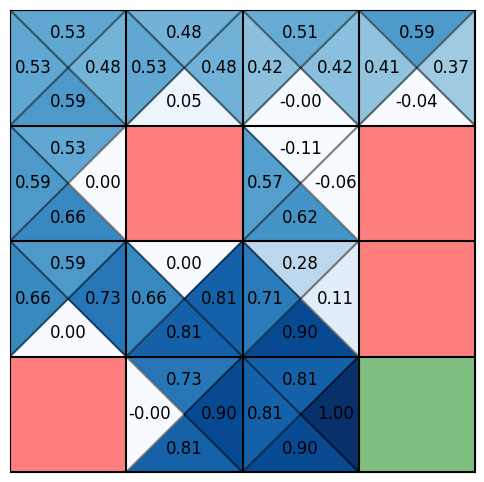

In [35]:
# Make a table of its predictions:
Q_table_nn = np.zeros((16, 4), dtype=np.float64)

for state in range(16):
    state_tensor = torch.tensor([state], dtype=torch.float32)
    Q_table_nn[state] = main_network.forward(state_tensor).detach().numpy()

plot_qvalues(Q_table_nn, env=env)


The algorithm is rather sensitive to many of the parameters. So if things are not working but you're convinced the code is correct, try varying the

- The epsilon strategy. 
- Number of episodes. 
- How often the target network is updated. 

### Other environments. 

<img src="images/cart_pole.gif" />

Now that we have a somewhat general DQN implementation, let's try it on an entirely different environment.

A consequence of using a neural network rather than a table that we have not 
discussed so far, is that we are able to handle environments with **continuous** 
observation/state spaces. 

An environment with a continuous observation space from `gymnasium` is [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/). This is a materials science problem where a materially wooden pole has to be balanced by the movement of a small material cart.

Look at the documentation, or play around with `env.observation_space` and `env.action_space` to figure out how this environment works. 

In [36]:
# Make the cartpole environment.
env = gym.make("CartPole-v1")

# Set the action and observation dimensions:
obs_dim = 4
n_actions = 2

# Set the network settings:
main_network = Qnet(input_dim=obs_dim, output_dim=n_actions)
target_network = Qnet(input_dim=obs_dim, output_dim=n_actions)
replay = ExperienceReplay(observation_dim=obs_dim, size=1000, batch_size=32)

# Make a learner:
learner = DQN(
    main_network=main_network,
    target_network=target_network,
    replay=replay,
    gamma=0.99,
    train_interval=1,
    copy_interval=100,
    epsilon=lambda i: 0.1
    )

num_episodes = 500
returns, lengths = learner.learn(env=env, num_episodes=num_episodes)

Output()

In [37]:
test_returns, test_lengths = learner.test(env=env, num_episodes=100, apply_epsilon=False)

Output()

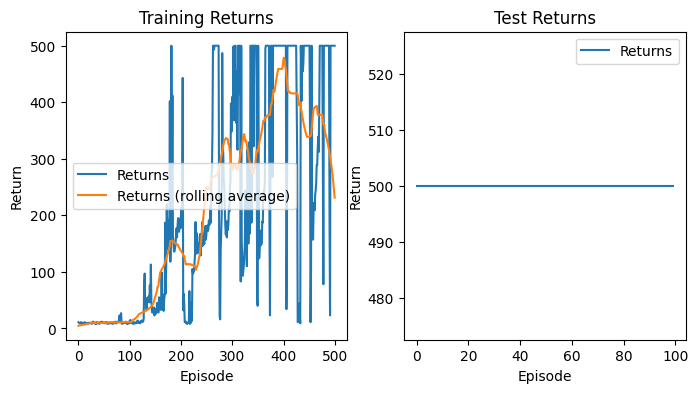

In [38]:
def rolling_average(x, N):
    return np.convolve(np.array(x).flatten(), np.ones((N,)) / N, mode="same")


fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(returns, label="Returns")
ax[0].plot(rolling_average(returns, 50), label="Returns (rolling average)")
ax[0].set_title("Training Returns")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Return")
ax[0].legend()

ax[1].plot(test_returns, label="Returns")
ax[1].set_title("Test Returns")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Return")
ax[1].legend()

The maximum return is 500, meaning that the agent balances the pole for 500 time steps, 
your agent should be able to do this quite consistent during testing.

The same implementation of our algorithm can solve problems that are completely different!